# Making an Anomalous Difference Map  
  
  
<font color=red>
    <em>
    Note: This section is currently handled in a hacky and imprecise way. This example will be updated in the near
    future to more properly reflect how to generate an anomalous difference map.
    </em>
</font>

In [Getting Started](gettingstarted.ipynb) we loaded a room-temperature dataset that was collected at ~6550 eV of tetragonal HEWL. Let's now use that data to generate an anomalous difference map based on the native anomalous signal from sulfur atoms. 

In [1]:
import reciprocalspaceship as rs
import numpy as np

In [2]:
refltable = rs.read_mtz("data/HEWL_SSAD_24IDC.mtz")
refltable.head()

FreeR_flag     IMEAN  SIGIMEAN      I(+)   SIGI(+)      I(-)  \
H K L                                                                  
0 0 4           14  671.0396 22.205784  671.0396 22.205784  671.0396   
    8            4 3273.7385 107.59589 3273.7385 107.59589 3273.7385   
    12           6 1367.5679 43.352566 1367.5679 43.352566 1367.5679   
    16          19   4158.55 198.88382   4158.55 198.88382   4158.55   
    20           8 2.4992087 5.7103205 2.4992087 5.7103205 2.4992087   

         SIGI(-)  N(+)  N(-)  
H K L                         
0 0 4  22.205784    16    16  
    8  107.59589    16    16  
    12 43.352566    16    16  
    16 198.88382     8     8  
    20 5.7103205     1     1

In [3]:
print(f"Number of reflections: {len(refltable)}")

Number of reflections: 12563


---
### Computing differences

In order to compute a difference map, let's first compute the differences in structure factor amplitude between Friedel pairs. We will do this in the following steps:

1. Filter out any reflections without observation of both Friedel pairs, or negative intensities
2. Filter out any centric reflections (Unnecessary)
3. Convert the observed intensities into structure factor amplitudes
4. Compute difference in magnitude between Friedel pairs ($F_{HKL}^+ - F_{HKL}^-$)

In [4]:
# 1. Filter out reflections without both Friedel pairs
refltable = refltable.loc[(refltable["N(+)"] > 0) & 
                          (refltable["N(-)"] > 0) &
                          (refltable["I(+)"] > 0) &
                          (refltable["I(-)"] > 0)]

In [5]:
print(f"Number of reflections: {len(refltable)}")

Number of reflections: 12333


In [6]:
# 2. Filter out centric reflections (Unnecessary; but they won't have anomalous signal)
refltable = refltable.loc[~refltable.label_centrics()["CENTRIC"]]

In [7]:
print(f"Number of reflections: {len(refltable)}")

Number of reflections: 10328


In [8]:
refltable.head()

FreeR_flag     IMEAN  SIGIMEAN      I(+)   SIGI(+)      I(-)   SIGI(-)  \
H K L                                                                           
2 1 1           0 199.67992 2.1387444 208.31882 3.0264542 191.06168 3.0228317   
    2          13  881.6192  9.878236  845.6465 13.966452  917.6278 13.973421   
    3           4 423.35788  4.799563  419.0855 6.7865486 427.63293 6.7886667   
    4          15  722.5178  8.301497  685.8678 11.732637  759.2611 11.747558   
    5          15 1415.0105 20.677141 1405.6847 29.239077   1424.34  29.24471   

       N(+)  N(-)  
H K L              
2 1 1    64    64  
    2    64    64  
    3    64    64  
    4    64    64  
    5    40    40

In [9]:
# 3. Convert intensities to structure factor amplitudes
refltable["F(+)"] = rs.DataSeries(np.sqrt(refltable["I(+)"].to_numpy()), dtype="SFAmplitudeFriedel").values
refltable["F(-)"] = rs.DataSeries(np.sqrt(refltable["I(-)"].to_numpy()), dtype="SFAmplitudeFriedel").values
refltable["SIGF(+)"] = rs.DataSeries(np.sqrt(refltable["SIGI(+)"].to_numpy()), dtype="StddevSFFriedel").values
refltable["SIGF(-)"] = rs.DataSeries(np.sqrt(refltable["SIGI(-)"].to_numpy()), dtype="StddevSFFriedel").values

In [10]:
# 4. Compute differences
dF    = refltable["F(+)"].to_numpy() - refltable["F(-)"].to_numpy()
sigDF = np.sqrt(refltable["SIGF(+)"].to_numpy()**2 + refltable["SIGF(-)"].to_numpy()**2)
refltable["dF"] = rs.DataSeries(dF, name="dF", dtype="SFAmplitude").values
refltable["SigDF"] = rs.DataSeries(sigDF, name="SigDF", dtype="Stddev").values

In [11]:
# Drop extraneous columns
refltable = refltable[["F(+)", "SIGF(+)", "F(-)", "SIGF(-)", "dF", "SigDF"]]
refltable.head()

F(+)   SIGF(+)      F(-)   SIGF(-)          dF     SigDF
H K L                                                              
2 1 1 14.433254 1.7396708 13.822506 1.7386292   0.6107483 2.4595296
    2 29.080002 3.7371716 30.292372 3.7381039  -1.2123699  5.285818
    3 20.471579 2.6051004 20.679287  2.605507 -0.20770836 3.6844559
    4 26.189077 3.4252937 27.554693  3.427471  -1.3656158 4.8456364
    5 37.492462  5.407317  37.74043  5.407838 -0.24796677 7.6474695

Let's plot the signal-to-noise of the observed anomalous difference signal

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

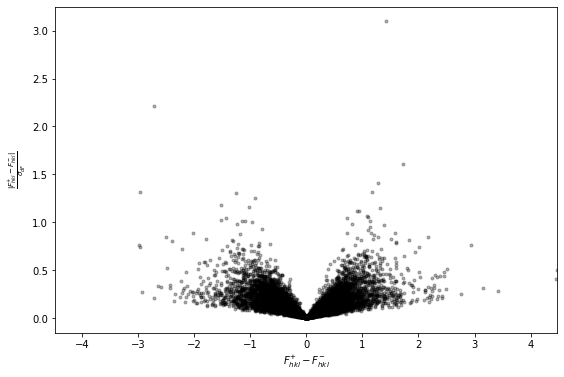

In [13]:
plt.figure(figsize=(9, 6))
plt.plot(refltable.dF.values, np.abs(refltable.dF.values)/refltable.SigDF.values, "k.", alpha=0.3)
plt.xlim(-refltable.dF.abs().max(), refltable.dF.abs().max())
plt.xlabel(r"$F_{hkl}^{+} - F_{hkl}^{-}$")
plt.ylabel(r"$\frac{|F_{hkl}^{+} - F_{hkl}^{-}|}{\sigma_{dF}}$")
plt.show()

---
### Obtaining Phases by Isomorphous Replacement

In order to turn these anomalous differences into a map, we need to get phases. We will do that by isomorphous replacement with a published structure, [1VAT](https://www.rcsb.org/structure/1vat). Phases were generated from the PDB model using [fmodel](https://www.phenix-online.org/documentation/reference/fmodel.html), and then we will compute the necessary phase shifts in order to go from the conventional structure factor phases to phases associated with the anomalous scattering contributions. 

In [14]:
ref = rs.read_mtz("data/1VAT_fmodel.mtz")

In [15]:
ref.head()

FMODEL     PHIFMODEL
H K L                         
0 0 4  954.69275         180.0
    8  1030.4215 -7.802343e-16
    12 754.23175 4.4153507e-15
    16  533.2781           0.0
    20 5.3535447           0.0

In [16]:
ref.dtypes

FMODEL       SFAmplitude
PHIFMODEL          Phase
dtype: object

In [17]:
# Find common HKL indices
hkls = refltable.index.intersection(ref.index)
hkls = hkls.sort_values()
refltable = refltable.loc[hkls]
ref = ref.loc[hkls]

In [18]:
print(f"Number of reflections: {len(refltable)}, {len(refltable)}")

Number of reflections: 10328, 10328


In [19]:
# This accounts for the phase shifts between the computed phases and the desired anomalous phases
refltable["PHANOM"] = ref["PHIFMODEL"]
refltable["PHANOM"] = refltable.apply(lambda x: x["PHANOM"] if x["dF"] < 0 else 180+x["PHANOM"], axis=1)
refltable["PHANOM"] += 90
refltable["PHANOM"] = rs.utils.canonicalize_phases(refltable["PHANOM"].astype("Phase"))

# Using the convention above for the phase shift, we need to take the |Fanom|
refltable["ANOM"] = np.abs(refltable["dF"]).astype("SFAmplitude")/2

In [20]:
refltable.write_mtz("data/anomdiff.mtz")

Looking at the map on the `1VAT` structure, we can see difference density on all of the sulfurs in HEWL. Here is an image of this density contoured at +5$\sigma$:  

![Anomalous Map](data/anomalousmap.png)